## Миронов С.В. ИУ5-62 Вариант 2(кластеризация)

In [1]:
#!pip install seaborn

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


In [17]:

import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import learning_curve, validation_curve

from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import silhouette_score
from itertools import cycle, islice


%matplotlib inline 

In [11]:
df = pd.read_csv('s1.txt', sep="    ", header=None)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [33]:
df.head()

,0,1
0,664159,550946
1,665845,557965
2,597173,575538
3,618600,551446
4,635690,608046


In [0]:
df.head()

In [55]:
cluster_n_samples = 1500

datasets_names = ['circles', 'moons', 'blobs', 'aniso', 'varied', 'no_structure']


def generate_datasets(n_samples):
    """
    Генерация набора данных на 1500 точек
    """
    noisy_circles, noisy_circles_y = datasets.make_circles(
        n_samples=n_samples, factor=0.9, noise=.01)
    noisy_moons, noisy_moons_y = datasets.make_moons(n_samples=n_samples, noise=.2)
    blobs, blobs_y = datasets.make_blobs(n_samples=n_samples, random_state=32)
    no_structure = np.random.rand(n_samples, 7)
  
    X_aniso, y_aniso = datasets.make_blobs(n_samples=n_samples, random_state=320)
    transformation = [[-0.6, 0.3], [-0.7, 0.1]]
    aniso = np.dot(X_aniso, transformation)

    varied, varied_y = datasets.make_blobs(
        n_samples=n_samples, 
        cluster_std=[3.5, 0.5, 2.5], 
        random_state=370)
    
    result_y = [noisy_circles_y, noisy_moons_y, varied_y, y_aniso, blobs_y]
    
    result_not_scaled = [noisy_circles, noisy_moons, 
                         varied, aniso, blobs, no_structure]
    
    # Нормализуем признаки
    result = []
    for data in result_not_scaled:
        data_res = StandardScaler().fit_transform(data)
        result.append(data_res)
    
    return result, result_y

In [56]:
def visualize_clusters(cluster_datasets, cluster_results):
    """
    Визуализация результатов кластерного анализа
    """
    plt.subplots(figsize=(10,7))
    plot_num = 0
    for X, y_pred in zip(cluster_datasets, cluster_results):
        plot_num += 1
        plt.subplot(2, 3, plot_num)
        # Цвета точек как результат кластеризации
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # черный цвет для выделяющихся значений
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=3, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.title(datasets_names[plot_num-1])
    
    plt.show()

In [57]:
def do_clustering(cluster_datasets, method):
    """
    Выполнение кластеризации для данных примера
    """
    cluster_results = []
    for X in cluster_datasets:
        temp_cluster = method.fit_predict(X)
        cluster_results.append(temp_cluster)
    return cluster_results

In [58]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [59]:
cluster_datasets, cluster_true_y = generate_datasets(cluster_n_samples)

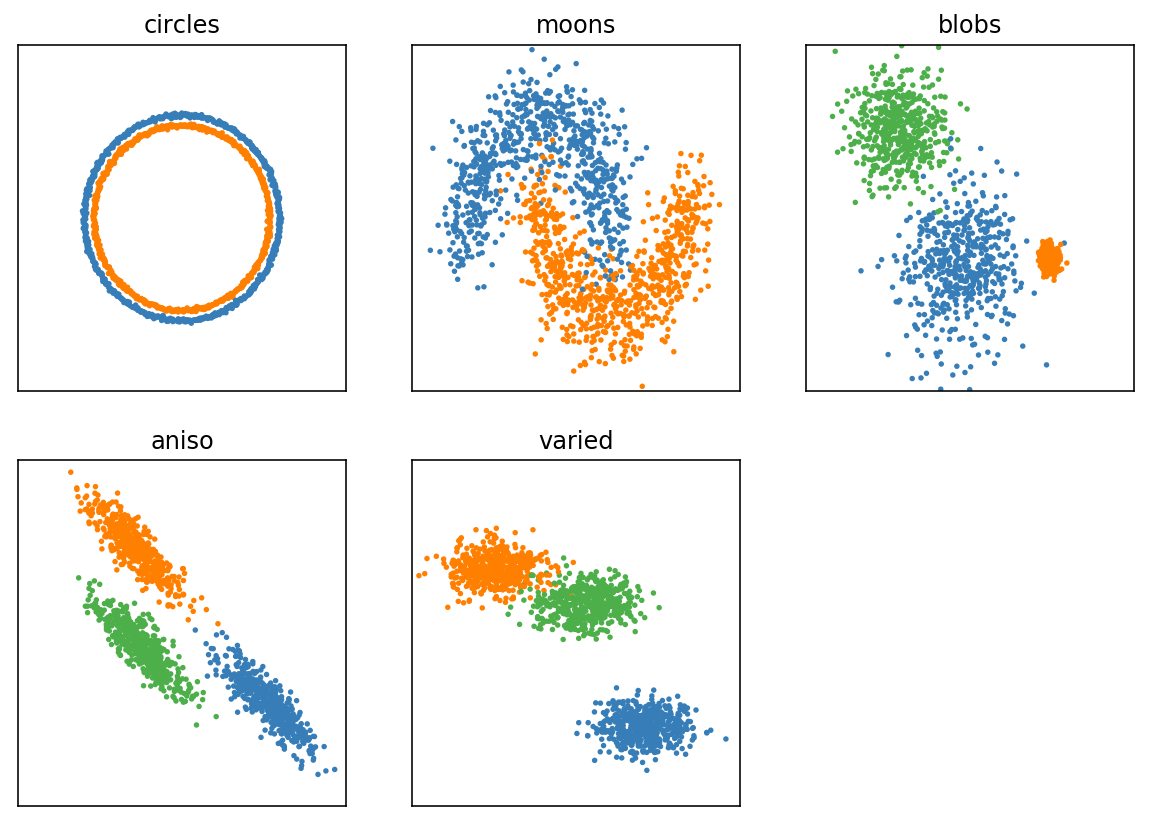

In [60]:
visualize_clusters(cluster_datasets, cluster_true_y)

In [63]:
%time result_KMeans_3 = do_clustering(cluster_datasets, KMeans(n_clusters=3))

CPU times: user 303 ms, sys: 208 ms, total: 511 ms
Wall time: 505 ms


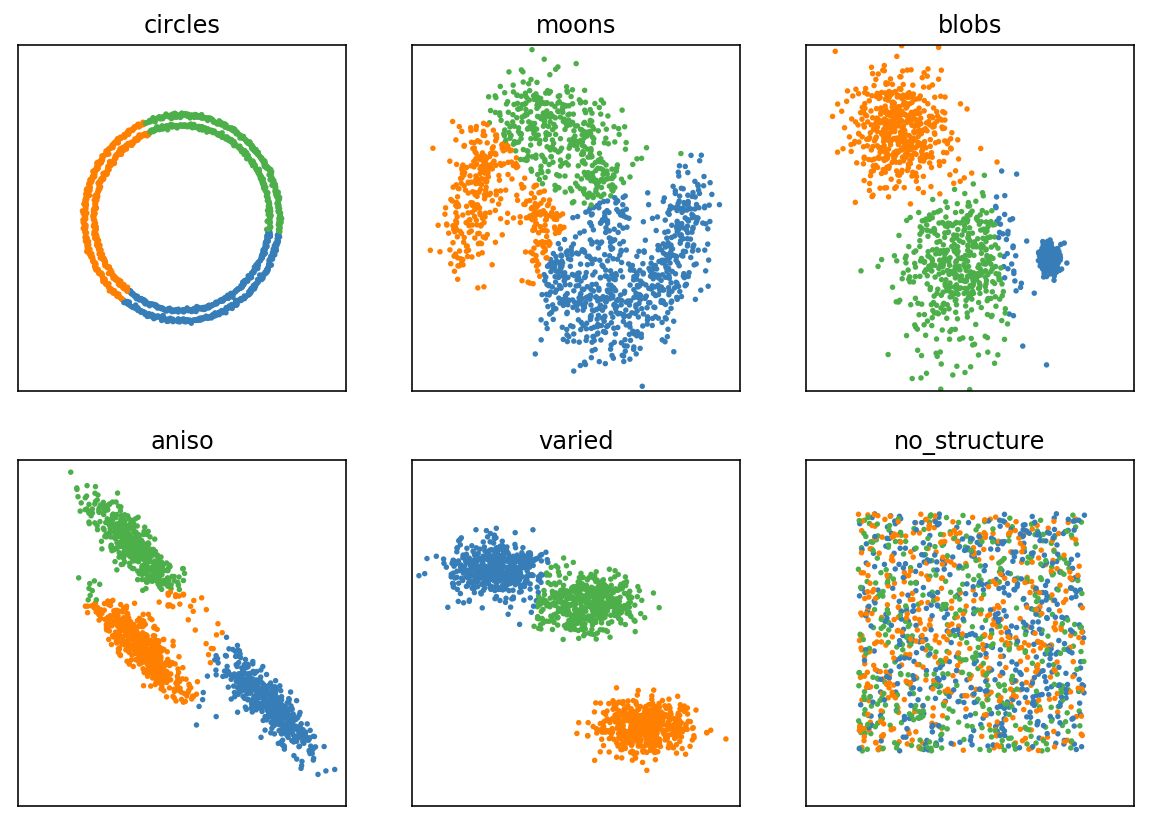

In [65]:
visualize_clusters(cluster_datasets, result_KMeans_3)

In [67]:
from sklearn.cluster import AffinityPropagation

In [68]:
%time result_AffinityPropagation = do_clustering(cluster_datasets, AffinityPropagation())

CPU times: user 55.2 s, sys: 1.15 s, total: 56.4 s
Wall time: 59 s


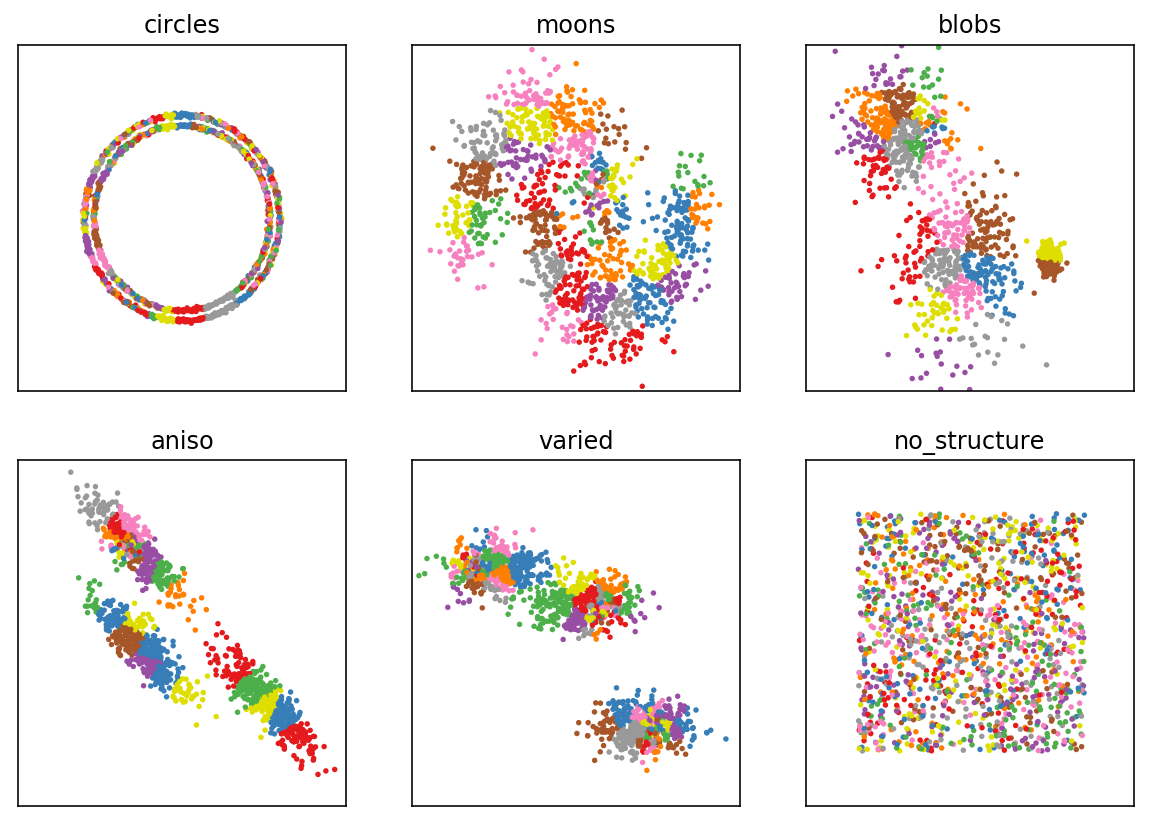

In [69]:
visualize_clusters(cluster_datasets, result_AffinityPropagation)

In [71]:
from sklearn.cluster import SpectralClustering

In [72]:
%time result_SpectralClustering = do_clustering(cluster_datasets, SpectralClustering())

CPU times: user 5.94 s, sys: 4.59 s, total: 10.5 s
Wall time: 10.6 s


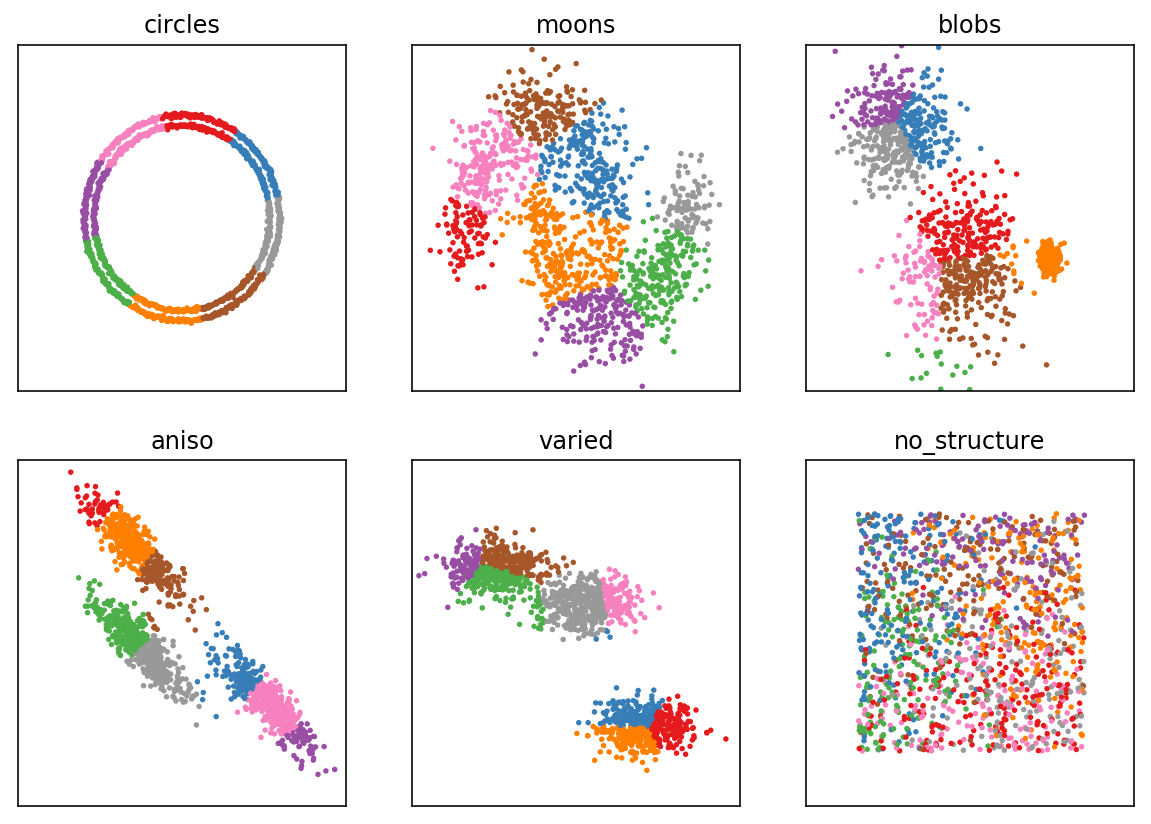

In [73]:
visualize_clusters(cluster_datasets, result_SpectralClustering)

In [74]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def claster_metrics(method, cluster_datasets, cluster_true_y, datasets_names):
    """
    Вычисление метрик кластеризации
    """
    ari = []
    ami = []
    hl = []
    cl = []
    vl = []
    sl = []
    for X, true_y in zip(cluster_datasets, cluster_true_y):
        temp_cluster = method.fit_predict(X)
        ari.append(adjusted_rand_score(true_y, temp_cluster))
        ami.append(adjusted_mutual_info_score(true_y, temp_cluster))
    
        h, c, v = homogeneity_completeness_v_measure(true_y, temp_cluster)
        hl.append(h)
        cl.append(c)
        vl.append(v)
    
        sl.append(silhouette_score(X, temp_cluster))
    
    result = pd.DataFrame({'Datasets':datasets_names[0:5], 
                           'ARI':ari, 'AMI':ami, 
                           'Homogeneity':hl, 
                           'Completeness':cl, 
                           'V-measure':vl, 'Silhouette':sl})
    return result

## Метрики для k средних

In [75]:
claster_metrics(KMeans(n_clusters=3), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,-0.000888,-0.000607,0.000002,0.000001,0.000001,0.470246
1,moons,0.395917,0.293977,0.447369,0.294425,0.355130,0.418815
2,blobs,0.893052,0.866318,0.866481,0.868750,0.867614,0.646185
3,aniso,0.914260,0.875655,0.875806,0.876036,0.875921,0.623058
4,varied,0.949284,0.926801,0.926890,0.926895,0.926892,0.669755


## Метрики для спектральной кластеризации

In [76]:
claster_metrics(SpectralClustering(), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,-0.001135,-0.001094,0.000097,0.000032,0.000049,0.488973
1,moons,0.205532,0.253531,0.740636,0.254397,0.378712,0.368644
2,blobs,0.604992,0.559580,0.935321,0.560714,0.701117,0.505368
3,aniso,0.521903,0.541265,0.964589,0.542367,0.694328,0.440729
4,varied,0.455050,0.491318,0.902213,0.492503,0.637180,0.307920


## Метрики для AffinityPropagation

In [77]:
claster_metrics( AffinityPropagation(), cluster_datasets, cluster_true_y, datasets_names)

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,circles,0.004507,0.025733,0.817080,0.094764,0.169831,0.097319
1,moons,0.055369,0.159887,0.867517,0.165458,0.277911,0.267576
2,blobs,0.299367,0.353782,0.967304,0.359323,0.523997,0.278822
3,aniso,0.167097,0.299909,0.991408,0.314595,0.477628,0.265528
4,varied,0.085877,0.220834,0.957495,0.245806,0.391187,0.149381
